한글 폰트 설정 완료 (Malgun Gothic)
'problem_data_final.xlsx'의 'Trade', 'Funding' 시트 로드 완료
잔차 표준편차(σ): 0.000267
정상 상한 범위 (+1.0σ): +0.000267
funding_ratio_vs_trade_amount_regression_TOPONLY.png 파일로 저장되었습니다.


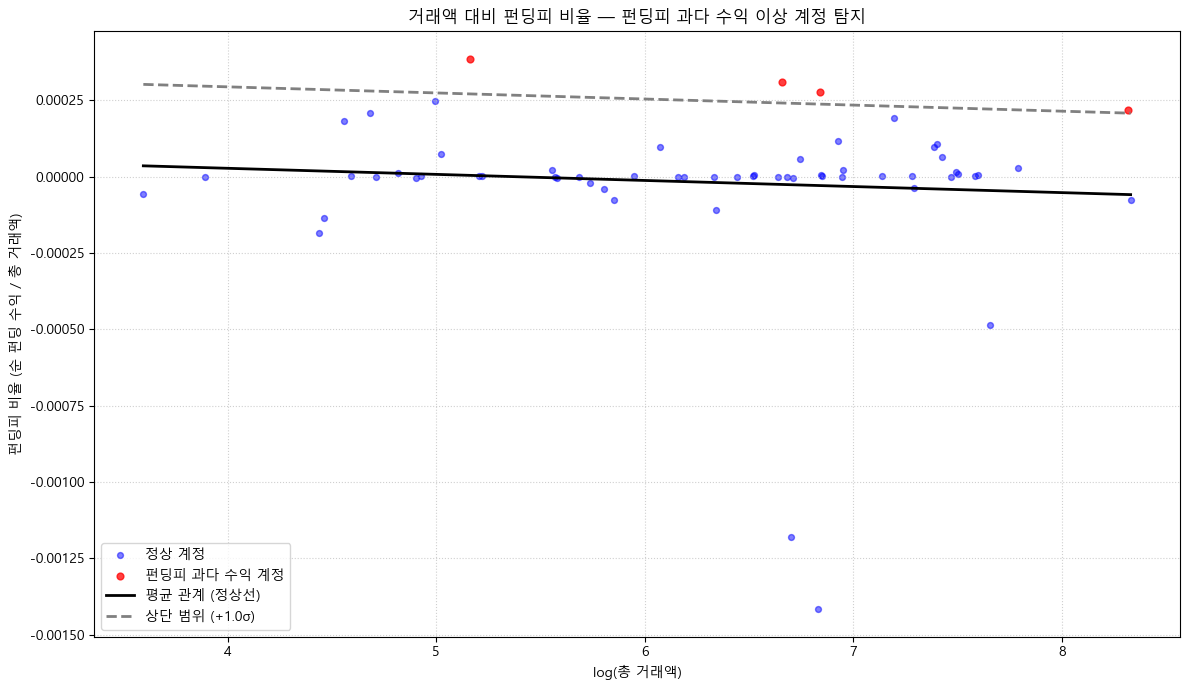

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def setup_korean_font():
    try:
        plt.rc('font', family='Malgun Gothic')   # 윈도우 기본 한글 폰트
        plt.rcParams['axes.unicode_minus'] = False
        print("한글 폰트 설정 완료 (Malgun Gothic)")
    except Exception as e:
        print(f"폰트 설정 오류: {e}")


# --- 1. 펀딩피 회귀-잔차 분석 시작 ---
setup_korean_font()

excel_file = 'problem_data_final.xlsx'

try:
    # 1) 데이터 로드
    df_trade = pd.read_excel(excel_file, sheet_name='Trade')
    df_funding = pd.read_excel(excel_file, sheet_name='Funding')
    print(f"'{excel_file}'의 'Trade', 'Funding' 시트 로드 완료")

    # 2) 사용자별 핵심 지표
    open_trades_agg = (
        df_trade[df_trade['openclose'] == 'OPEN']
        .groupby('account_id', as_index=False)['amount']
        .sum()
        .rename(columns={'amount': 'total_open_amount'})
    )

    net_funding_fee = (
        df_funding.groupby('account_id', as_index=False)['funding_fee']
        .sum()
        .rename(columns={'funding_fee': 'net_funding_fee'})
    )

    df_agg = pd.merge(open_trades_agg, net_funding_fee, on='account_id', how='left')
    df_agg['net_funding_fee'] = df_agg['net_funding_fee'].fillna(0)

    # 거래 0인 계정 제거
    df_agg = df_agg[df_agg['total_open_amount'] > 0].copy()

    # 3) 지표 계산 (로그/비율)
    eps = 1e-12
    df_agg.loc[:, 'log_trade_amount'] = np.log10(df_agg['total_open_amount'] + eps)
    df_agg.loc[:, 'funding_ratio'] = df_agg['net_funding_fee'] / df_agg['total_open_amount']

    # 극단치 제거(상/하위 1%)
    p_low = df_agg['funding_ratio'].quantile(0.01)
    p_high = df_agg['funding_ratio'].quantile(0.99)
    df_agg_cleaned = df_agg.loc[(df_agg['funding_ratio'] > p_low) & (df_agg['funding_ratio'] < p_high)].copy()

    # 유효 값만 사용
    mask_finite = np.isfinite(df_agg_cleaned['log_trade_amount']) & np.isfinite(df_agg_cleaned['funding_ratio'])
    df_agg_cleaned = df_agg_cleaned.loc[mask_finite].copy()

    X = df_agg_cleaned[['log_trade_amount']].values
    y = df_agg_cleaned['funding_ratio'].values

    # 4) 선형 회귀
    model = LinearRegression()
    model.fit(X, y)
    df_agg_cleaned.loc[:, 'predicted_ratio'] = model.predict(X)

    # 5) 잔차/밴드 – 정상 범위를 좁게: 1.5σ 사용
    df_agg_cleaned.loc[:, 'residual'] = df_agg_cleaned['funding_ratio'] - df_agg_cleaned['predicted_ratio']
    residual_std = float(df_agg_cleaned['residual'].std(ddof=1))

    sigma_level = 1.0  # 1.0시그마 = 상위 16%검출
    df_agg_cleaned.loc[:, 'upper_band'] = df_agg_cleaned['predicted_ratio'] + (sigma_level * residual_std)

    print(f"잔차 표준편차(σ): {residual_std:.6f}")
    print(f"정상 상한 범위 (+{sigma_level}σ): +{sigma_level * residual_std:.6f}")

    # 6) 라벨링 — 상단만 이상 처리
    df_agg_cleaned.loc[:, 'status'] = np.where(
        df_agg_cleaned['funding_ratio'] > df_agg_cleaned['upper_band'],
        '이상 (Abnormal)',      # 펀딩피 과다 수익 계정
        '정상 (Normal)'
    )

    # 시각화용 정렬
    plot_df = df_agg_cleaned.sort_values('log_trade_amount')
    df_normal = df_agg_cleaned[df_agg_cleaned['status'] == '정상 (Normal)']
    df_abnormal = df_agg_cleaned[df_agg_cleaned['status'] == '이상 (Abnormal)']

    plt.figure(figsize=(12, 7))
    # 정상(파란 점)
    plt.scatter(df_normal['log_trade_amount'], df_normal['funding_ratio'],
                alpha=0.5, label='정상 계정', color='blue', s=18)
    # 이상(빨간 점)
    plt.scatter(df_abnormal['log_trade_amount'], df_abnormal['funding_ratio'],
                alpha=0.75, label='펀딩피 과다 수익 계정', color='red', s=24)

    # 회귀선/상단밴드
    plt.plot(plot_df['log_trade_amount'], plot_df['predicted_ratio'],
             color='black', linestyle='-', linewidth=2, label='평균 관계 (정상선)')
    plt.plot(plot_df['log_trade_amount'], plot_df['upper_band'],
             color='gray', linestyle='--', linewidth=2, label=f'상단 범위 (+{sigma_level}σ)')

    plt.title('거래액 대비 펀딩피 비율 — 펀딩피 과다 수익 이상 계정 탐지')
    plt.xlabel('log(총 거래액)')
    plt.ylabel('펀딩피 비율 (순 펀딩 수익 / 총 거래액)')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    plt.savefig('funding_ratio_vs_trade_amount_regression_TOPONLY.png', dpi=150)
    print("funding_ratio_vs_trade_amount_regression_TOPONLY.png 파일로 저장되었습니다.")

except FileNotFoundError:
    print(f"오류: '{excel_file}' 파일을 찾을 수 없습니다.")
except Exception as e:
    if 'No sheet named' in str(e):
        print(f"오류: '{excel_file}' 파일에 필요한 시트(Trade/Funding)가 없습니다.")
    elif 'openpyxl' in str(e):
         print("오류: 'openpyxl' 라이브러리가 필요합니다. (pip install openpyxl scikit-learn)")
    else:
        print(f"오류 발생: {e}")
